# Realtime Hand Sign translation with CNN

## Initial setup - imports, loading data, utility functions

In [6]:
# %pip install mediapipe opencv-python matplotlib pandas tensorflow

Note: you may need to restart the kernel to use updated packages.


In [10]:
# imports for data processing
import os
import mediapipe as mp
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('default')

In [11]:
# data dir paths
unprocessed_data_dir = 'datasets/compiled_1000_asl_dataset/unprocessed'
processed_data_dir = 'datasets/compiled_1000_asl_dataset/train'
test_data_dir = 'datasets/compiled_1000_asl_dataset/test'

class_label_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'blank']

### Functions for preprocessing images

In [39]:
# media pipe hands object
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False, min_detection_confidence=0.9, min_tracking_confidence=0.9
)

# function to create image with landmarks
def get_hand_landmarks_image(frame):
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # draw landmarks on blank 224x224 white image
    output_img = np.ones((224, 224, 3), np.uint8) * 255

    results = hands.process(image_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(
                output_img,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                # landmark_drawing_spec=mp_drawing.DrawingSpec(color=(20), thickness=2, circle_radius=2),
                # connection_drawing_spec=mp_drawing.DrawingSpec(color=(20), thickness=2, circle_radius=2),
                landmark_drawing_spec=mp_drawing.DrawingSpec(color=(20,20,20), thickness=2, circle_radius=2),
                connection_drawing_spec=mp_drawing.DrawingSpec(color=(20,20,20), thickness=2, circle_radius=2),
            )
    return bool(results.multi_hand_landmarks), output_img

# function to get processed image with edge detection of hand by applying grayscale, blur and edge detection
def get_processed_image(frame):
    minValue = 70
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),2)

    th3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,11,2)
    ret, res = cv2.threshold(th3, minValue, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    res = cv2.cvtColor(res, cv2.COLOR_GRAY2BGR)
    return True, res

### Dataset creation (Optional)

#### Create dataset from webcam

In [ ]:
cap = cv2.VideoCapture(0)

# function for preprocessing images
img_processing_func = [get_hand_landmarks_image, get_processed_image][0]

# create dataset for ASL characters A-Z and blank

n_images_per_class = 333

for index, label in enumerate(class_label_list):
    os.makedirs(os.path.join(processed_data_dir, str(index)), exist_ok=True)
    curr_img = 0
    print(f"Capturing images for {label}...", end='')
    while curr_img < n_images_per_class:
        ret, frame = cap.read()
        if not ret: continue

        # Preprocess the frame to match the input size of the model and scale the pixel values
        frame = frame[:, 80:560]
        frame = cv2.resize(frame, (224, 224))

        # get hand landmarks image with mediapipe
        success, hand_landmarks_img = img_processing_func(frame)

        # save image
        if success:
            cv2.imwrite(os.path.join(processed_data_dir, str(index), f'{curr_img + 2 * n_images_per_class + 1}.jpg'), hand_landmarks_img)
            curr_img += 1

        preview_img = hand_landmarks_img.copy()
        frame_label = f'Finished {label}. press space' if curr_img == n_images_per_class else f'{label} {curr_img}/{n_images_per_class-1}' 
        cv2.putText(preview_img, frame_label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 200), 2, cv2.LINE_AA)
        cv2.imshow('Preview', preview_img)

        if curr_img == n_images_per_class:
            print("Done!")
            while True:
                if cv2.waitKey(1) & 0xFF == ord(' '):
                    break
        
        cv2.waitKey(200)

cap.release()
cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

#### Create data after image processing from unprocessed data

In [8]:
# generate images from unprocessed_data_dir to processed_data_dir
img_processing_func = [get_hand_landmarks_image, get_processed_image][0]

# loop through all directores in unprocessed_data_dir
for dir in os.listdir(unprocessed_data_dir):
    print(f'Processing {dir}...', end='')

    # create output dir and test dir
    output_dir = os.path.join(processed_data_dir, dir)
    os.makedirs(output_dir, exist_ok=True)

    # loop through all files in dir
    for file in os.listdir(os.path.join(unprocessed_data_dir, dir)):
        # load image
        image_rgb = cv2.imread(os.path.join(unprocessed_data_dir, dir, file))

        # process image
        ret, processed_image = img_processing_func(image_rgb)

        # save image
        if ret:
            cv2.imwrite(os.path.join(output_dir, file), processed_image)
        else:
            print(f'  Error in pre-processing {dir}/{file}')
    
    print(f'Done!')

Processing 0...

c:\Users\Kamin\anaconda3\envs\fyp\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Done!
Processing 1...Done!
Processing 10...Done!
Processing 11...Done!
Processing 12...Done!
Processing 13...Done!
Processing 14...  Error in pre-processing 14/264.jpg
Done!
Processing 15...  Error in pre-processing 15/12.jpg
  Error in pre-processing 15/13.jpg
  Error in pre-processing 15/220.jpg
  Error in pre-processing 15/221.jpg
  Error in pre-processing 15/222.jpg
  Error in pre-processing 15/223.jpg
  Error in pre-processing 15/224.jpg
  Error in pre-processing 15/230.jpg
  Error in pre-processing 15/236.jpg
  Error in pre-processing 15/237.jpg
  Error in pre-processing 15/238.jpg
  Error in pre-processing 15/239.jpg
  Error in pre-processing 15/240.jpg
  Error in pre-processing 15/241.jpg
  Error in pre-processing 15/242.jpg
  Error in pre-processing 15/243.jpg
  Error in pre-processing 15/244.jpg
  Error in pre-processing 15/245.jpg
  Error in pre-processing 15/246.jpg
  Error in pre-processing 15/247.jpg
  Error in pre-processing 15/248.jpg
  Error in pre-processing 15/249.jp

#### Create blank images for no hand sign

In [9]:
# create blank image when no hands are detected
os.makedirs(os.path.join(processed_data_dir, '26'), exist_ok=True)
n_images = 333
output_img = np.ones((224, 224, 3), np.uint8) * 255
for i in range(n_images):
    cv2.imwrite(os.path.join(processed_data_dir, '26', f'{i}.jpg'), output_img)

### Preview dataset

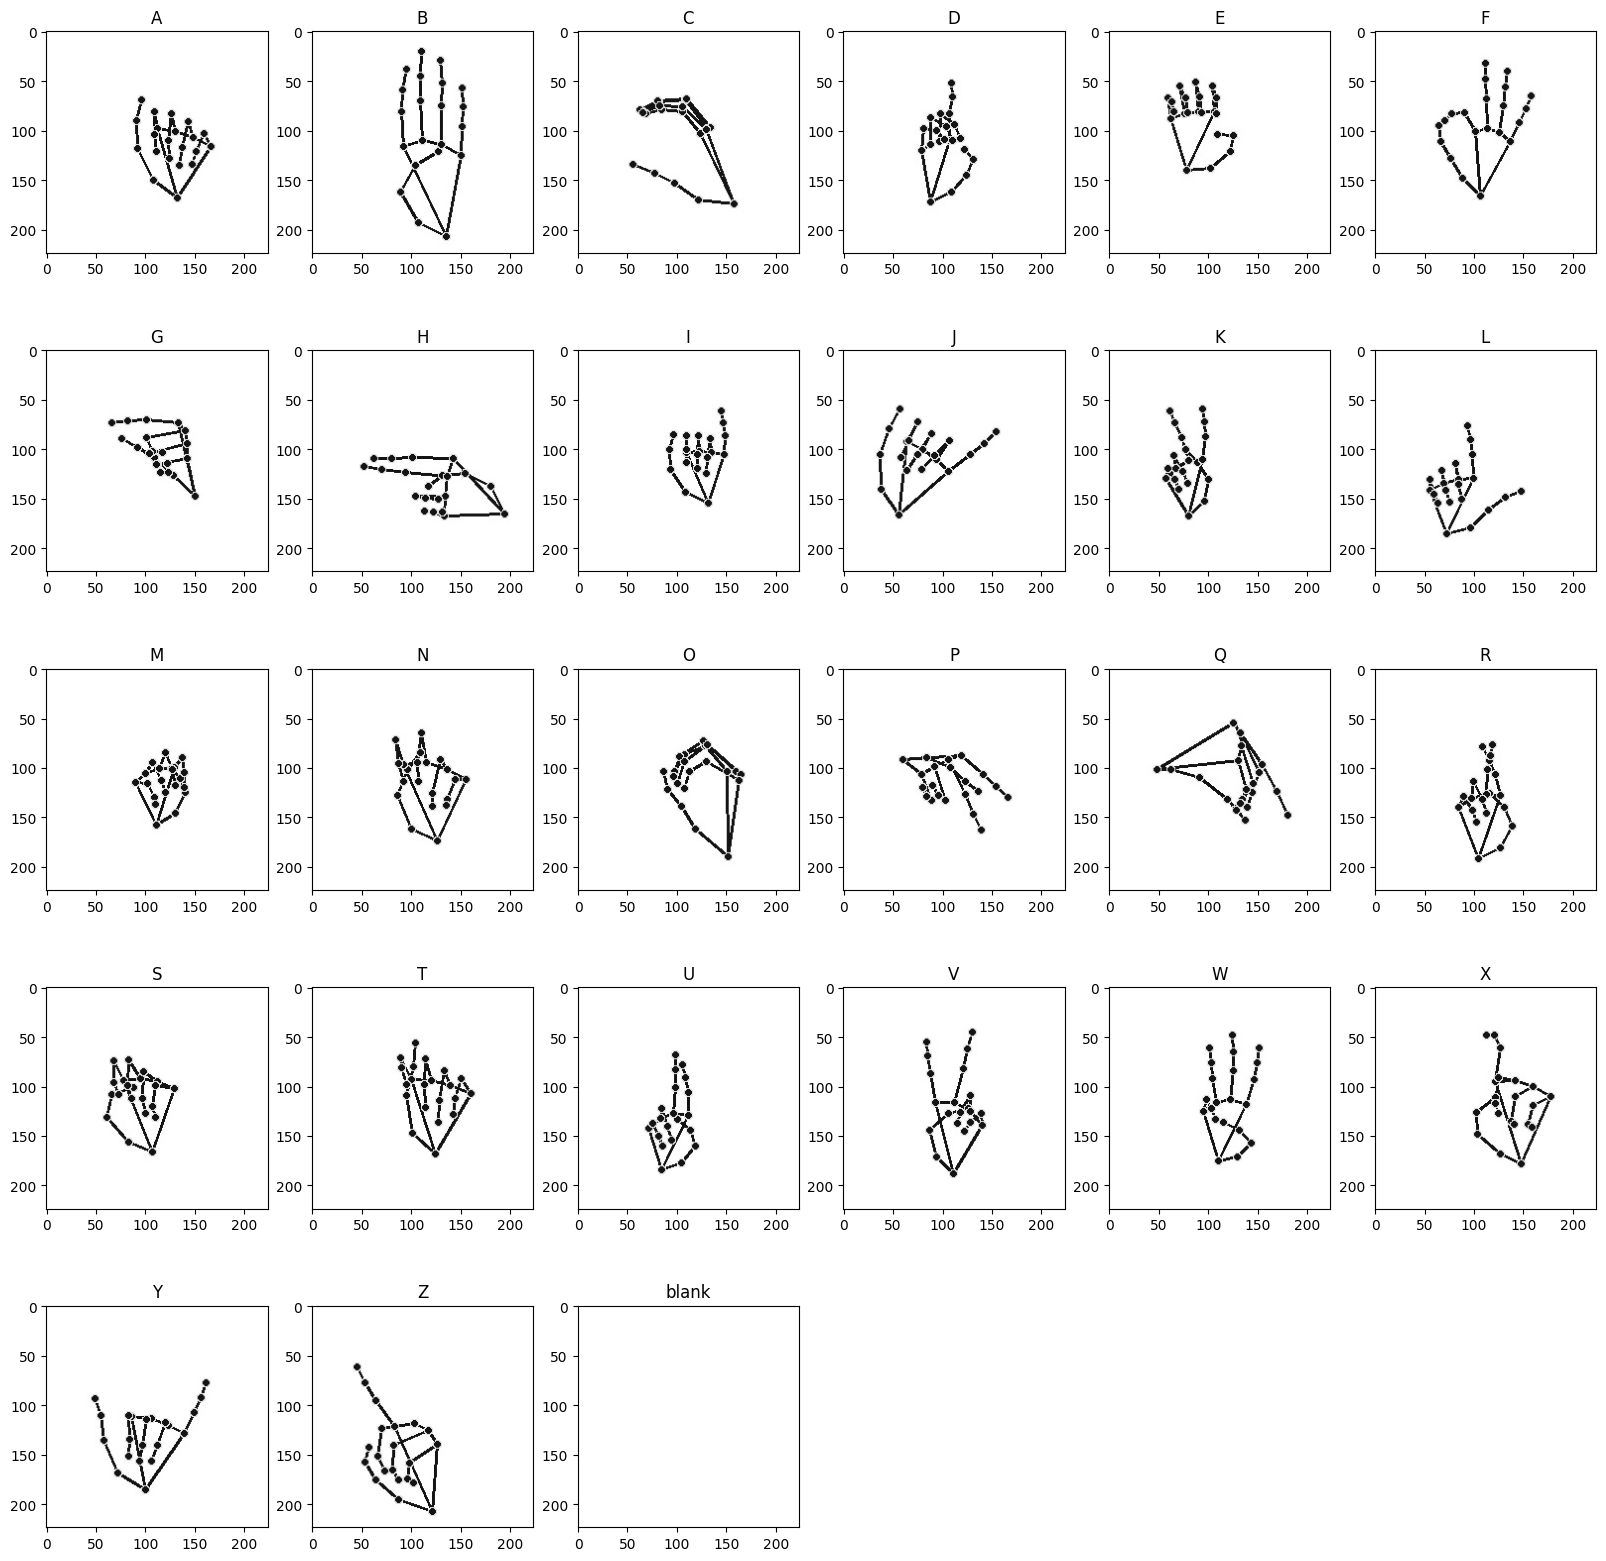

In [5]:
import random

# show image from each of the classes from processed_data_dir on notebook

fig, axs = plt.subplots(5, 6, figsize=(20, 20))

class_dirs = os.listdir(processed_data_dir)
for class_dir in class_dirs:
    class_dir_path = os.path.join(processed_data_dir, class_dir)
    img_files = os.listdir(class_dir_path)

    img_path = os.path.join(class_dir_path, random.choice(img_files))
    img = cv2.imread(img_path)
    axs[int(class_dir) // 6, int(class_dir) % 6].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[int(class_dir) // 6, int(class_dir) % 6].set_title(class_label_list[int(class_dir)])

for ax in axs.flat[len(class_dirs):]:
    ax.axis('off')

## ASL CNN model

### Define and train model

In [13]:
# imports for model training/testing
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
from tensorflow.keras.optimizers import Adam
import datetime

##### Prepare dataset for training

Split data to train and test by moving data from processed_data_dir to test_data_dir

In [11]:
import random

# move 15% of files from processed_data_dir to test_data_dir
os.makedirs(test_data_dir, exist_ok=True)
for dir in os.listdir(processed_data_dir):
    output_dir = os.path.join(test_data_dir, dir)
    os.makedirs(output_dir, exist_ok=True)

    files = os.listdir(os.path.join(processed_data_dir, dir))
    n_files = len(files)
    n_test_files = int(n_files * 0.15)

    random_files = random.sample(files, k=n_test_files)

    for file in random_files:
        os.rename(os.path.join(processed_data_dir, dir, file), os.path.join(test_data_dir, dir, file))

Create dataset using ImageDataGenerator

In [14]:
train_datagen = ImageDataGenerator(validation_split=0.1765, horizontal_flip=True, rescale=1./255, rotation_range=12, zoom_range=0.2, height_shift_range=0.2, width_shift_range=0.2, shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    processed_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',     # grayscale
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    processed_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',     # grayscale
    subset='validation')

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='grayscale',     # grayscale
    class_mode='categorical')

# class labels
class_label_dict = train_generator.class_indices
class_label_dict = {v: k for k, v in class_label_dict.items()}
print('Class labels:', class_label_dict)

Found 18900 images belonging to 27 classes.
Found 4050 images belonging to 27 classes.
Found 4050 images belonging to 27 classes.
Class labels: {0: '0', 1: '1', 2: '10', 3: '11', 4: '12', 5: '13', 6: '14', 7: '15', 8: '16', 9: '17', 10: '18', 11: '19', 12: '2', 13: '20', 14: '21', 15: '22', 16: '23', 17: '24', 18: '25', 19: '26', 20: '3', 21: '4', 22: '5', 23: '6', 24: '7', 25: '8', 26: '9'}


##### Model definition

In [ ]:
model = Sequential([
    # Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),     # grayscale
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(27, activation='softmax')
])

In [8]:
# adam_optimizer = Adam(learning_rate=0.0001)
# model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# callbacks for model training

logs_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
csv_logger = CSVLogger('training.log')
tensorboard_callback = TensorBoard(log_dir=logs_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(train_generator, epochs=40, validation_data=validation_generator, callbacks=[early_stopping, csv_logger, tensorboard_callback])

In [27]:
# model.save('run4_grayscale_compiled_dataset_model_added_layers_generalized.keras')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

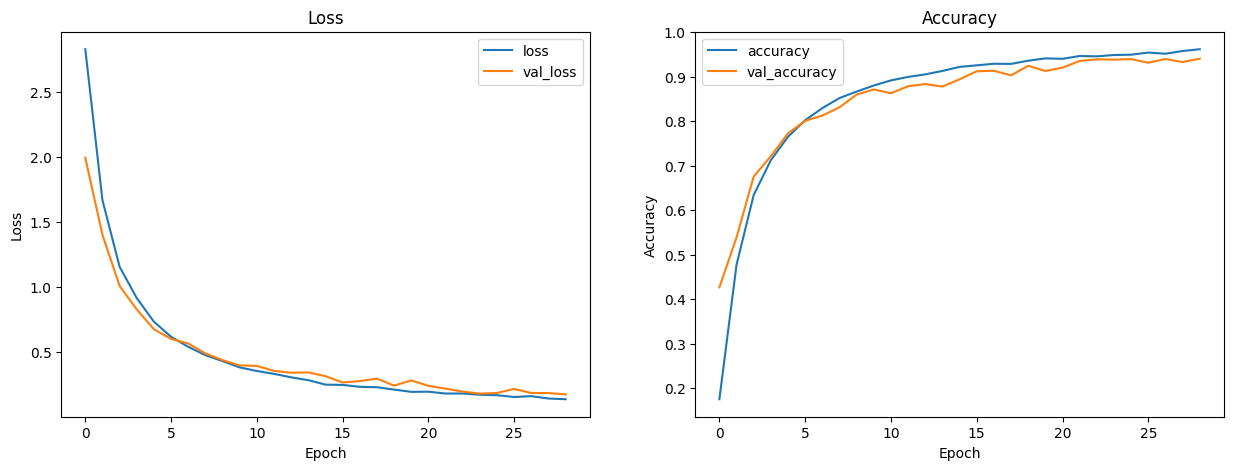

In [4]:
# plot the training and validation accuracy and loss at each epoch from training.log using pandas and maatplotlib
log = pd.read_csv('logs/dataset_1000_grayscale_model_training.log')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.set_facecolor('white')

axs[0].plot(log['loss'], label='loss')
axs[0].plot(log['val_loss'], label='val_loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(log['accuracy'], label='accuracy')
axs[1].plot(log['val_accuracy'], label='val_accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

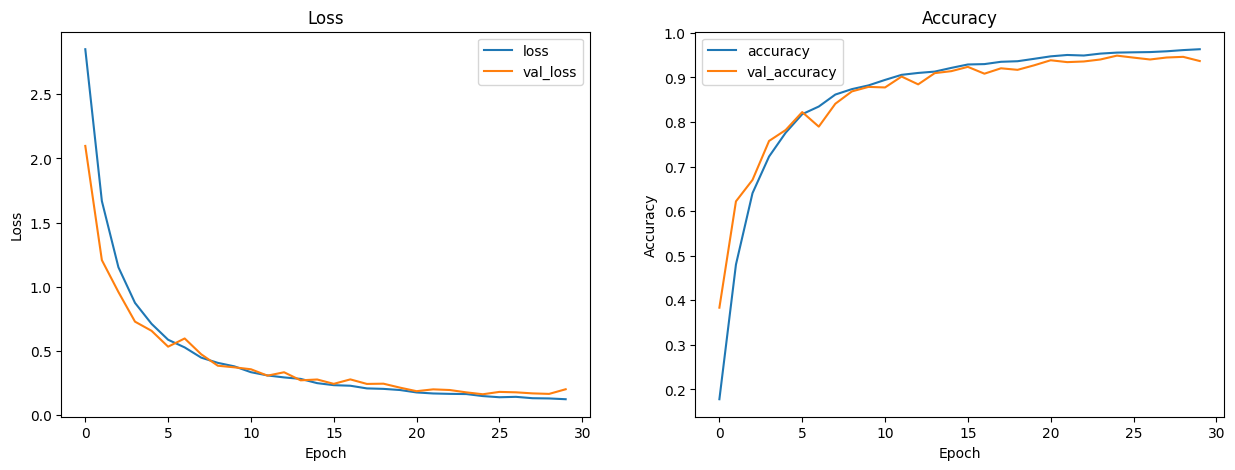

In [13]:
# plot the training and validation accuracy and loss at each epoch from training.log using pandas and maatplotlib
log = pd.read_csv('training.log')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.set_facecolor('white')

axs[0].plot(log['loss'], label='loss')
axs[0].plot(log['val_loss'], label='val_loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(log['accuracy'], label='accuracy')
axs[1].plot(log['val_accuracy'], label='val_accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

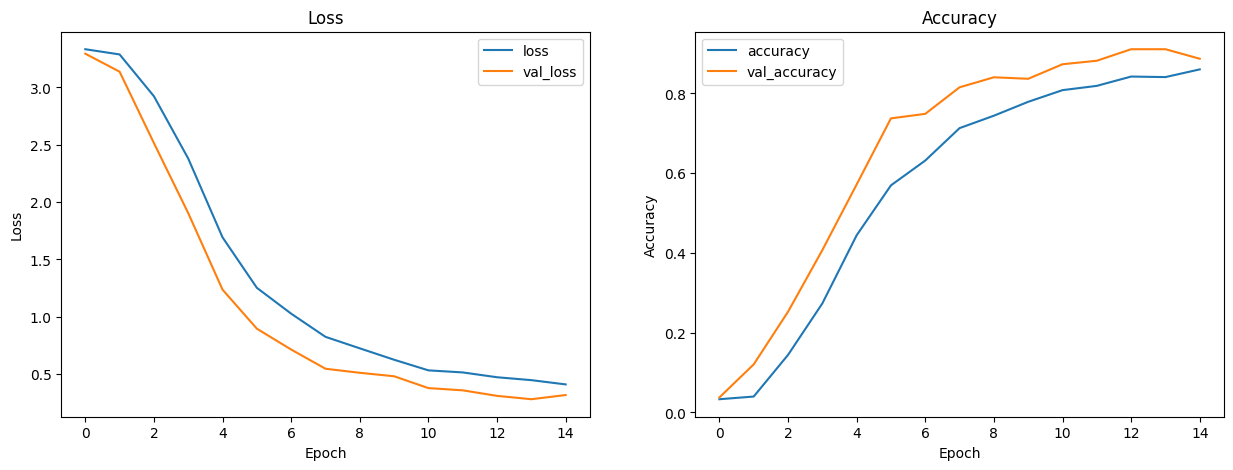

In [31]:
# plot the training and validation accuracy and loss at each epoch from training.log using pandas and maatplotlib
log = pd.read_csv('training.log')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.set_facecolor('white')

axs[0].plot(log['loss'], label='loss')
axs[0].plot(log['val_loss'], label='val_loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(log['accuracy'], label='accuracy')
axs[1].plot(log['val_accuracy'], label='val_accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

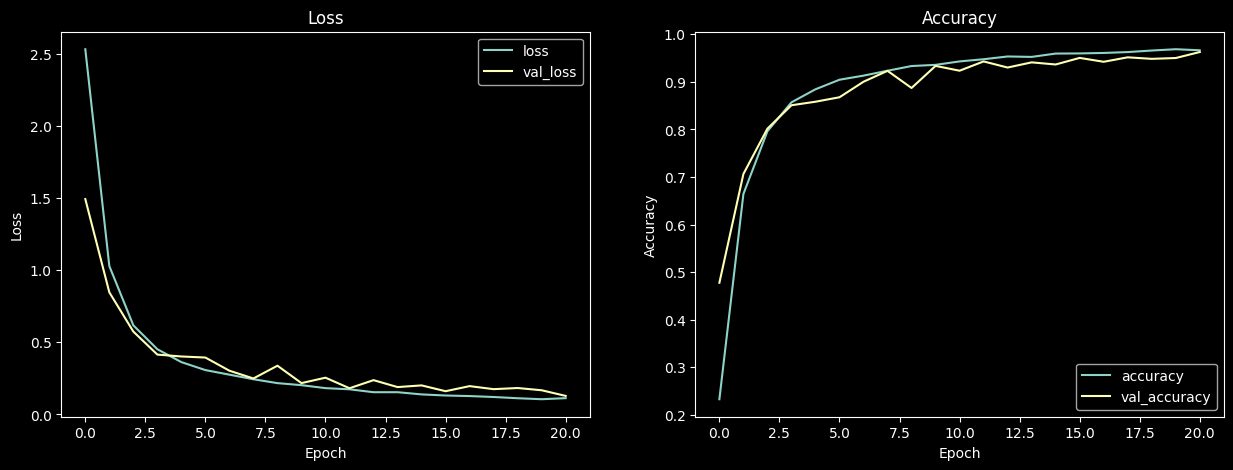

In [29]:
# plot the training and validation accuracy and loss at each epoch from training.log using pandas and maatplotlib

import pandas as pd

log = pd.read_csv('training.log')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(log['loss'], label='loss')
axs[0].plot(log['val_loss'], label='val_loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(log['accuracy'], label='accuracy')
axs[1].plot(log['val_accuracy'], label='val_accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

In [20]:
# model.save('kaggle_1000_asl_dataset_model.keras')

### Test model

In [15]:
# load model
model = load_model('run3_grayscale_compiled_dataset_model_generalized.keras')

#### Test with static image

In [32]:
# test accuracy of model on test data
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

  1/254 ━━━━━━━━━━━━━━━━━━━━ 42s 168ms/step - accuracy: 1.0000 - loss: 1.3041e-04

c:\Users\Kamin\anaconda3\envs\fyp\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


254/254 ━━━━━━━━━━━━━━━━━━━━ 64s 250ms/step - accuracy: 0.9801 - loss: 0.1075
Test accuracy: 0.9828395247459412


In [ ]:
# test image
image_rgb = cv2.imread(processed_data_dir + '/20/499.jpg')

added_dim_img = np.expand_dims(image_rgb, axis=0)

prediction = model.predict(added_dim_img)
predicted_class = np.argmax(prediction)

print(f'Predicted class: {class_label_dict[predicted_class]}')

#### Test with realtime video from webcam

In [28]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 27)             │        13,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,829,715 (220.60 MB)

 Trainable params: 19,276,571 (73.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,553,144 (147.07 MB)

In [40]:
cap = cv2.VideoCapture(0)

# function for preprocessing images
img_processing_func = [get_hand_landmarks_image, get_processed_image][0]

while True:
    ret, frame = cap.read()
    if not ret: continue

    # Preprocess the frame to match the input size of the model and scale the pixel values
    frame = frame[:, 80:560]
    frame = cv2.resize(frame, (224, 224))

    # get hand landmarks image with mediapipe
    _, hand_landmarks_img = img_processing_func(frame)
    
    # Add an extra dimension because the model expects batches of images
    # added_dim_img = np.expand_dims(hand_landmarks_img, axis=0)
    gray_img = cv2.cvtColor(hand_landmarks_img, cv2.COLOR_BGR2GRAY)   # grayscale
    added_dim_img = np.expand_dims(gray_img, axis=(0, 3))     # grayscale

    # Use the model to predict the class of the frame
    prediction = model.predict(added_dim_img)

    # Get the class with the highest probability
    predicted_class = np.argmax(prediction)
    predicted_class_label = class_label_dict[predicted_class]
    
    # Display the predicted class on the frame and print it
    sign = ' ' if predicted_class_label == '26' else chr(65 + int(predicted_class_label))
    cv2.putText(hand_landmarks_img, sign, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 128), 2)

    # Display the resulting frame
    cv2.imshow('Hand Landmarks', hand_landmarks_img)
    
    # Check for 'q' or escape key press to exit the loop
    if cv2.waitKey(1) & 0xFF in [ord('q'), ord('Q'), 27]:
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [33]:
cap.release()
cv2.destroyAllWindows()